In [1]:
import numpy as np
from PIL import Image

from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
IMG_LENGTH = 512
IMG_BREADTH = 512
MEAN_B_VALUE = 123.68
MEAN_G_VALUE = 116.779
MEAN_R_VALUE = 103.939

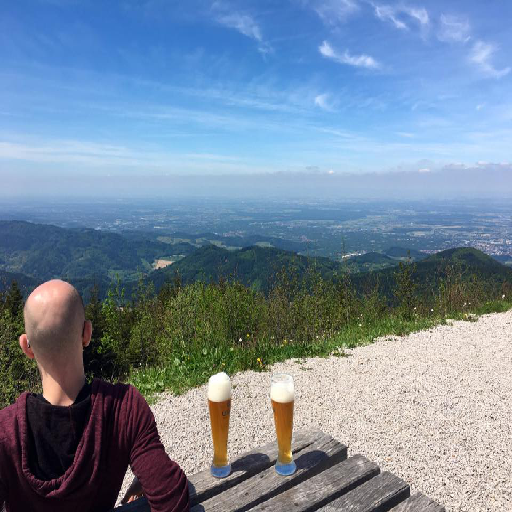

In [3]:
inp_img = Image.open('content_image.jpg')
size = inp_img.size
inp_img = inp_img.resize((IMG_BREADTH, IMG_LENGTH))
inp_img

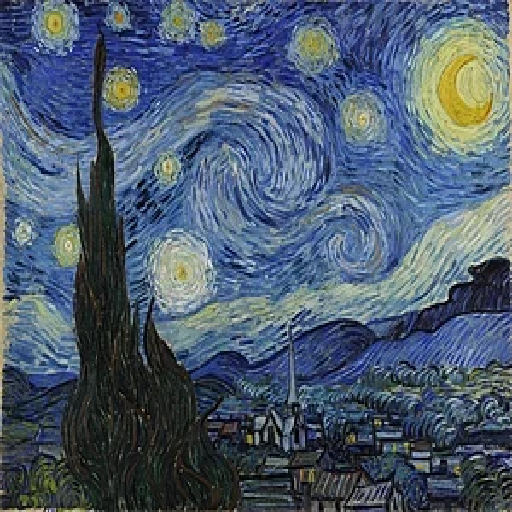

In [4]:
style_img = Image.open('style_image.jpg').resize((IMG_BREADTH, IMG_LENGTH))
style_img

In [5]:
inp_img_array = np.asarray(inp_img, dtype="float32")
inp_img_array = np.expand_dims(inp_img_array, axis=0)
inp_img_array[:, :, :, 0] -= MEAN_R_VALUE
inp_img_array[:, :, :, 1] -= MEAN_G_VALUE
inp_img_array[:, :, :, 2] -= MEAN_B_VALUE
inp_img_array = inp_img_array[:, :, :, ::-1]
print(inp_img_array.shape)

style_img_array = np.asarray(style_img, dtype="float32")
style_img_array = np.expand_dims(style_img_array, axis=0)
style_img_array[:, :, :, 0] -= MEAN_R_VALUE
style_img_array[:, :, :, 1] -= MEAN_G_VALUE
style_img_array[:, :, :, 2] -= MEAN_B_VALUE
style_img_array = style_img_array[:, :, :, ::-1]
print(style_img_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [6]:
inp_img = backend.variable(inp_img_array)
style_img = backend.variable(style_img_array)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
net_img = backend.placeholder((1, IMG_BREADTH, IMG_LENGTH, 3))
inp = backend.concatenate([inp_img,style_img,net_img], axis=0)

In [0]:
model = VGG19(input_tensor=inp, include_top=False)

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [0]:
CONTENT_WEIGHT = 0.05
STYLE_WEIGHT = 10
TOTAL_VARIATION_WEIGHT = 1
TOTAL_VARIATION_LOSS_FACTOR = 1.25
CHANNELS = 3
ITERATIONS = 150

In [11]:
layers = dict()
for layer in model.layers:
    layers[layer.name] = layer.output

content_layer = "block4_conv2"
layer_features = layers[content_layer]
content_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_features, combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    result = backend.dot(features, backend.transpose(features))
    return result

def style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMG_LENGTH * IMG_BREADTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss(style_features, combination_features)

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMG_BREADTH-1, :IMG_LENGTH-1, :] - x[:, 1:, :IMG_LENGTH-1, :])
    b = backend.square(x[:, :IMG_BREADTH-1, :IMG_LENGTH-1, :] - x[:, :IMG_BREADTH-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(net_img)

In [0]:
outputs = [loss]
outputs += backend.gradients(loss, net_img)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMG_BREADTH, IMG_LENGTH, CHANNELS))
    outs = backend.function([net_img], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteration 0 completed with loss 1382.565642
Iteration 1 completed with loss 578.893414
Iteration 2 completed with loss 406.227272
Iteration 3 completed with loss 335.681823
Iteration 4 completed with loss 303.415235
Iteration 5 completed with loss 283.343421
Iteration 6 completed with loss 270.648832
Iteration 7 completed with loss 261.452431
Iteration 8 completed with loss 254.956749
Iteration 9 completed with loss 249.364685
Iteration 10 completed with loss 245.260780
Iteration 11 completed with loss 242.134159
Iteration 12 completed with loss 239.033098
Iteration 13 completed with loss 236.289393
Iteration 14 completed with loss 234.350920
Iteration 15 completed with loss 232.674570
Iteration 16 completed with loss 230.883062
Iteration 17 completed with loss 229.542502
Iteration 18 completed with loss 228.502036
Iteration 19 completed with loss 227.434598
Iteration 20 completed with loss 226.566922
Iteration 21 completed with loss 225.650319
Iteration 22 completed with loss 224.8096

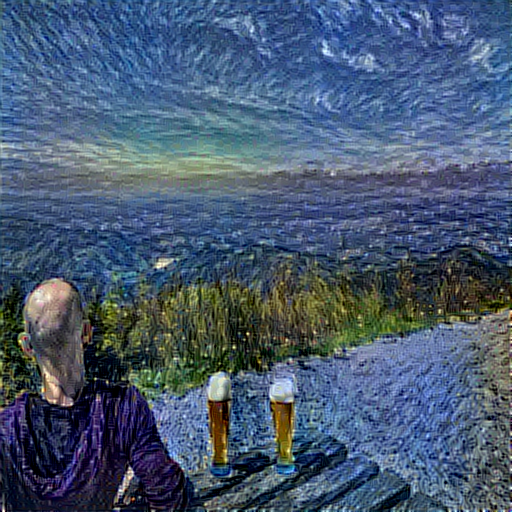

In [15]:
x = np.random.uniform(0, 255, (1, IMG_BREADTH, IMG_LENGTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %f" % (i, loss/100000000))
    
x = x.reshape((IMG_BREADTH, IMG_LENGTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += MEAN_R_VALUE
x[:, :, 1] += MEAN_G_VALUE
x[:, :, 2] += MEAN_B_VALUE
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image

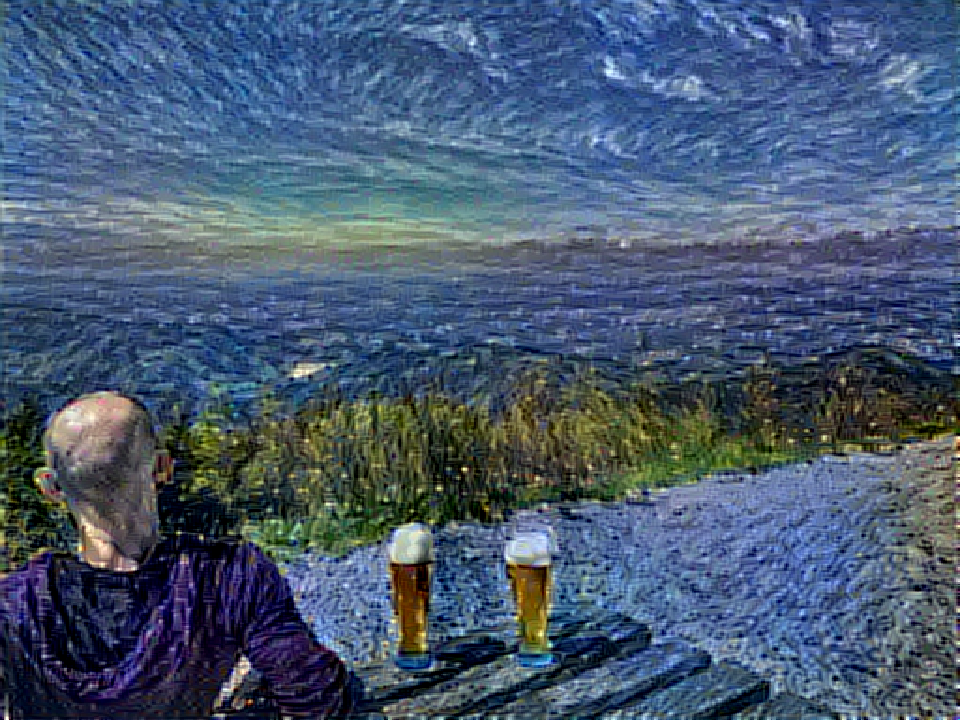

In [16]:
output_image = output_image.resize(size)
output_image